In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from datetime import datetime, timedelta, date

2023-05-03 11:37:55.473569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('train.csv')
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.year.astype('str')+ '-' + df['date'].dt.month.astype('str')+ '-' + '01'
df = df[['month','sales']]
df['month'] = pd.to_datetime(df['month'])
df = df.groupby('month').sum().reset_index()
df.head()
# df.head()

,month,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


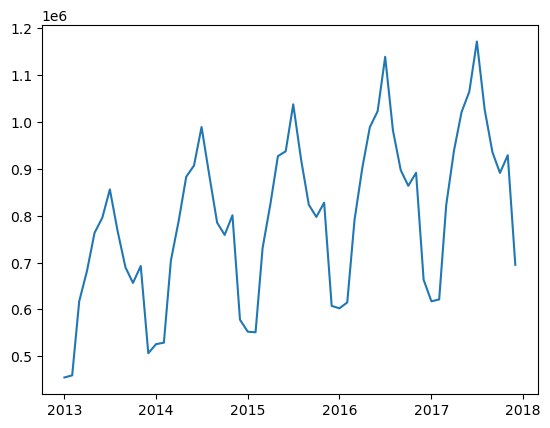

In [3]:
plt.plot(df['month'],df['sales'])
plt.show()

# Preparing Train/Test Data

In [4]:
df_sales = df.copy()

for i in range(12):
    df_sales['x'+str(i)] = df_sales['sales'].shift(i+1)

df_sales = df_sales.dropna().reset_index(drop = True)

# for i in range(12):
#     df_sales['x'+str(i)] = df_sales['sales']-df_sales['x'+str(i)]
    
df_sales.head(12)

,month,sales,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,2014-01-01,525987,506607.0,692643.0,656587.0,689907.0,766761.0,855922.0,795597.0,763242.0,682274.0,617382.0,459417.0,454904.0
1,2014-02-01,529117,525987.0,506607.0,692643.0,656587.0,689907.0,766761.0,855922.0,795597.0,763242.0,682274.0,617382.0,459417.0
2,2014-03-01,704301,529117.0,525987.0,506607.0,692643.0,656587.0,689907.0,766761.0,855922.0,795597.0,763242.0,682274.0,617382.0
3,2014-04-01,788914,704301.0,529117.0,525987.0,506607.0,692643.0,656587.0,689907.0,766761.0,855922.0,795597.0,763242.0,682274.0
4,2014-05-01,882877,788914.0,704301.0,529117.0,525987.0,506607.0,692643.0,656587.0,689907.0,766761.0,855922.0,795597.0,763242.0
5,2014-06-01,906842,882877.0,788914.0,704301.0,529117.0,525987.0,506607.0,692643.0,656587.0,689907.0,766761.0,855922.0,795597.0
6,2014-07-01,989010,906842.0,882877.0,788914.0,704301.0,529117.0,525987.0,506607.0,692643.0,656587.0,689907.0,766761.0,855922.0
7,2014-08-01,885596,989010.0,906842.0,882877.0,788914.0,704301.0,529117.0,525987.0,506607.0,692643.0,656587.0,689907.0,766761.0
8,2014-09-01,785124,885596.0,989010.0,906842.0,882877.0,788914.0,704301.0,529117.0,525987.0,506607.0,692643.0,656587.0,689907.0
9,2014-10-01,758883,785124.0,885596.0,989010.0,906842.0,882877.0,788914.0,704301.0,529117.0,525987.0,506607.0,692643.0,656587.0


In [23]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='sales ~ x0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11', data=df_sales)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.979526021769606


In [5]:
df_sales.drop('month',axis = 1, inplace = True)

In [6]:
train_data, test_data = df_sales[0:-6].values,df_sales[-6:].values
print(train_data.shape,test_data.shape)

(42, 13) (6, 13)


In [7]:
train_data[0:2]

array([[525987., 506607., 692643., 656587., 689907., 766761., 855922.,
        795597., 763242., 682274., 617382., 459417., 454904.],
       [529117., 525987., 506607., 692643., 656587., 689907., 766761.,
        855922., 795597., 763242., 682274., 617382., 459417.]])

In [8]:
sc = MinMaxScaler(feature_range=(-1,1))
train_data_scaled = sc.fit_transform(train_data)

# train_data_scaled = train_data_scaled.reshape(-1,train_data.shape[1],1)
X_train,y_train = train_data_scaled[:,1:],train_data_scaled[:,0:1]
X_train = X_train.reshape(-1,X_train.shape[1],1)

# X_test,y_test = test_data[:,1:],test_data[:,0:1]
test_data_scaled = sc.transform(test_data)
X_test = test_data_scaled[:,1:]
X_test = X_test.reshape(-1,X_train.shape[1],1)
original_sales = test_data[:,0:1]

print(X_train.shape,X_test.shape)

(42, 12, 1) (6, 12, 1)


In [9]:
original_sales

array([[1171393.],
       [1026403.],
       [ 935263.],
       [ 891160.],
       [ 928837.],
       [ 695170.]])

In [10]:
regressorLSTM = Sequential([
    LSTM(units = 10, input_shape = (12,1)),
    Dropout(0.2),
    # LSTM(units = 50, return_sequences = True),
    # Dropout(0.2),
    # LSTM(units = 50, return_sequences = True),
    # Dropout(0.2),
    # LSTM(units = 5),
    Dense(1)
])

regressorLSTM.compile(optimizer='adam',loss='mse')
regressorLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
histLSTM = regressorLSTM.fit(X_train,y_train,epochs = 100,batch_size = 32)

Epoch 1/100
2/2 [==============================] - 1s 8ms/step - loss: 0.2146
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 0.2116
Epoch 3/100
2/2 [==============================] - 0s 6ms/step - loss: 0.2148
Epoch 4/100
2/2 [==============================] - 0s 5ms/step - loss: 0.2089
Epoch 5/100
2/2 [==============================] - 0s 5ms/step - loss: 0.2198
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: 0.2260
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 0.2027
Epoch 8/100
2/2 [==============================] - 0s 5ms/step - loss: 0.2276
Epoch 9/100
2/2 [==============================] - 0s 5ms/step - loss: 0.2064
Epoch 10/100
2/2 [==============================] - 0s 5ms/step - loss: 0.2010
Epoch 11/100
2/2 [==============================] - 0s 5ms/step - loss: 0.2024
Epoch 12/100
2/2 [==============================] - 0s 5ms/step - loss: 0.1997
Epoch 13/100
2/2 [==============================] - 0s 6ms/st

In [12]:
y_pred = regressorLSTM.predict(X_test)
y_pred = y_pred.reshape(-1,1,y_pred.shape[1])

y_pred.shape
y_pred
# predicted_sales = sc.inverse_transform(y_pred)
# predicted_sales

1/1 [==============================] - 0s 315ms/step


array([[[ 0.62446105]],

       [[ 0.42394906]],

       [[ 0.26433867]],

       [[ 0.10905646]],

       [[-0.0972572 ]],

       [[-0.55929744]]], dtype=float32)

In [13]:
y_pred.shape

(6, 1, 1)

In [14]:
X_test.shape

(6, 12, 1)

In [15]:
pred_test_set = [] 
for i in range(len(y_pred)):
    # print(np.concatenate([y_pred[i],X_test[i]],axis = 0))
    pred_test_set.append(np.concatenate([y_pred[i],X_test[i]],axis=0))
    
# y_pred
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(-1,pred_test_set.shape[1])
pred_test_values = sc.inverse_transform(pred_test_set)
pred_sales = pred_test_values[:,0]
pred_sales

array([1023665.82328492,  962235.86660668,  913336.74946597,
        865763.63624576,  802556.25024214,  661003.05939931])

In [16]:
original_sales

array([[1171393.],
       [1026403.],
       [ 935263.],
       [ 891160.],
       [ 928837.],
       [ 695170.]])

In [17]:
r2_score(original_sales,pred_sales)

0.6421777892390959

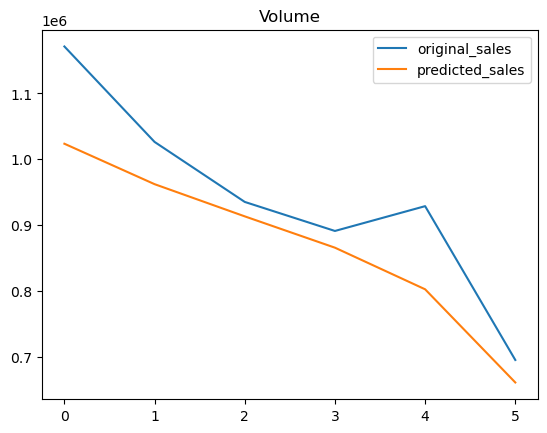

In [18]:
plt.plot(original_sales,label = 'original_sales')
plt.plot(pred_sales, label = 'predicted_sales')
plt.title('Sales Volume')
plt.title('Volume')
plt.legend()
plt.show()

In [32]:
# df_test = pd.read_csv('test.csv')
# df_test.tail()

df_test = pd.read_csv('test.csv')
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['month'] = df_test['date'].dt.year.astype('str')+ '-' + df_test['date'].dt.month.astype('str')+ '-' + '01'
df_test = df_test[['month','item']]
df_test['month'] = pd.to_datetime(df_test['month'])
df_test = df_test.groupby('month').sum().reset_index()
df_test.rename(columns={'item':'sales'},inplace = True)
df_test.head()
# df.head()

,month,sales
0,2018-01-01,395250
1,2018-02-01,357000
2,2018-03-01,395250


In [30]:
df.tail()

,month,sales
55,2017-08-01,1026403
56,2017-09-01,935263
57,2017-10-01,891160
58,2017-11-01,928837
59,2017-12-01,695170


In [37]:
df_total = pd.concat([df,df_test],axis = 0).reset_index(drop = True)
df_total.tail()

,month,sales
58,2017-11-01,928837
59,2017-12-01,695170
60,2018-01-01,395250
61,2018-02-01,357000
62,2018-03-01,395250
